In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2

### Extracting data

In [2]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
keras.utils.get_file(filename, url)


with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")


### utilities

In [23]:
def compute_iou(rois, boxes): 
    
    '''
        compute the pairwise IOU between rois and boxes and return a matrix of all iou score 
        where the coefficient (ith,jth) of the ith row, jth colomun is the iou score between the ith roi and jth boxe
    '''
    
    # convert all boxes and rois to corner coordinates
    rois = convert_to_corner(rois) 
    boxes = convert_to_corner(boxes)
    
    print("rois", rois)
    print("boxes", boxes)
    
    # getting minmum coordinates between all rois and each of the gt boxes
    
    xmin1, ymin1, xmax1, ymax1 = tf.split(value=rois, num_or_size_splits=4, axis=1) 
    xmin2, ymin2, xmax2, ymax2 = tf.split(value=boxes, num_or_size_splits=4, axis=1)
    
    x_min = tf.maximum(xmin1, tf.transpose(xmin2))
    y_min = tf.maximum(ymin1, tf.transpose(ymin2)) 
    
    x_max = tf.minimum(xmax1, tf.transpose(xmax2)) 
    y_max = tf.minimum(ymax1, tf.transpose(ymax2))
    
    width = tf.maximum(0.0, x_max - x_min)
    height = tf.maximum(0.0, y_max - y_min) 
    
    intersection = width * height
#     print("intersection : ", intersection) 
#     print()
    
    # computing the union (let's not forget to remove the intersection)
    roi_union = (xmax1 - xmin1) * (ymax1 - ymin1)
    boxes_union = (xmax2 - xmin2) * (ymax2 - ymin2)
    
#     print("roi union", roi_union) 
#     print("boxes_union", boxes_union) 
    
#     print("after expanding roi", tf.expand_dims(roi_union, 1))
#     print("after expanding boxes", tf.expand_dims(boxes_union, 0))
    
#     print("")
    full_union = tf.add(roi_union , tf.transpose(boxes_union)) # union with intersection
    proper_union = full_union - intersection
#     print("complete union", full_union)
    
    iou = intersection / proper_union
    
    return iou
    
    
    
def preprocess_data(sample): 
    """
        return image, bbox, cls
    """
    image = sample["image"] 
    bbox = convert_to_xywh(sample["objects"]["bbox"]) 
    class_id  = sample["objects"]["label"]
            
    bbox = scale_bbox_up(bbox, (tf.cast(tf.shape(image)[0], tf.float32), tf.cast(tf.shape(image)[1], tf.float32))) 
    image = tf.make_ndarray(image)
    return image, bbox, class_id 
    
    

In [4]:
class ROI: 
    
    '''
        class responsible for generating ROI using Selective Search
        ROI's shapes : x, y, w, h
    '''
    
    
    def __init__(self, resize_width=96, resize_height=96): 
        self.height = resize_width 
        self.width = resize_height
        
    def generate_roi(self, image, roi_nb, scale=True): 
        '''
            return roi_nb ROI for the image of shape : x, y, w, h
            Arguments: 
                image : the actual sample image 
                roi_nb : the number of roi to extract from the image
        '''
        
        # TODO `| RESIZE THE ROI !
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()[:roi_nb]
        
        rects = tf.cast(tf.stack([rects[:,0], rects[:,1], rects[:,2], rects[:,3]], axis=-1), dtype=tf.float32)
        if scale: 
            rects = scale_bbox_down(rects, (image.shape[0], image.shape[1]))
        return rects

In [5]:
def convert_to_xywh(boxes): 
    '''
        Convert boxes with corner coordinates to xywh coordinates
        
        Arguments: 
            boxes: Tensor of size (num_boxes,4) 
    '''
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3] - boxes[:, 1], boxes[:,2] - boxes[:,0]], axis=-1)


def scale_bbox_up(boxes, image_shape): 
    
    '''
        Scale boxes with format xywh
    '''
    
    y_scale = image_shape[0]
    x_scale = image_shape[1] 
    return tf.stack([boxes[:, 0] * x_scale, boxes[:, 1] * y_scale, boxes[:, 2] * x_scale, boxes[:,3] * y_scale], axis=-1)


def scale_bbox_down(boxes, image_shape): 
    
    '''
        Scale boxes with format xywh
    '''
    
    y_scale = image_shape[0]
    x_scale = image_shape[1] 
    return tf.stack([boxes[:, 0] / x_scale, boxes[:, 1] / y_scale, boxes[:, 2] / x_scale, boxes[:,3] / y_scale], axis=-1)


def convert_to_corner(boxes): 
    
    
    '''
        concert a batch of (xmin, ymin, w, h) boxes to (xmin, ymin, xmax, ymax)
    '''
    
    return tf.stack([boxes[:,0], boxes[:,1], boxes[:,0] + boxes[:,2], boxes[:,1] + boxes[:,3]], axis=-1)

In [6]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)


### let's visualize some samples

In [7]:
class LabelEncoder: 
    
    '''
        The raw labels, consisting of bounding boxes and class ids need to be transformed into targets for training. 
        This transformation consists of the following steps:
            - Assigning ground truth boxes to the ROI boxes
            - The ROI boxes that are not assigned any objects, are either assigned the background class or ignored depending on the IOU
            - Generating the classification and regression targets using ROI boxes
    
    '''
    
    def __init__(self): 
        roi = ROI()
        
    def _match_roi_boxes(self, rois, gt_boxes, match_iou=0.5, ignore_iou=0.4): 
        
        """
            Matches ground truth boxes to rois boxes based on the IOU matrix
            Returns  
                [0] : a (number_of_rois, 1) tensor of  arg max indexes (for each roi)
                [1] : a (number_or_rois, 1) tensor with values of 1 if the corresponding bbox is a positive sample and 0 if not
                [2] : a (number_or_rois, 1) tensor with values of 1 if the corresponding bbox is a background (neg) sample and 0 if not

        """
        
        iou_matrix = compute_iou(rois, gt_boxes)
        print("iou matrix") 
        print(iou_matrix)
        max_iou = tf.reduce_max(iou_matrix, axis=-1)
        max_idx = tf.math.argmax(iou_matrix, axis=-1)
        positives = tf.greater_equal(max_iou, match_iou) # truth 
        negatives = tf.less(max_iou, ignore_iou) # truth
        # rest is being ignored 
        ignore = tf.logical_not(tf.logical_or(positives, negatives))
        print("MAX INDEX : ")
        print(max_idx)
        print()
        return max_idx, tf.cast(positives, dtype=tf.float32), tf.cast(ignore, dtype=tf.float32)
    
    def _get_box_target(self, gt_boxes, matched_rois): 
        """
            Calculate the regression targets for the training pair (gt_box, matched_roi)
            the regressor is configured to learn scale-invariant transformation between two centers and log-scale transformation between widths and heights.
            An obvious benefit of applying such transformation is that all the bounding box correction functions, di(p) where i∈{x,y,w,h}, can take any value between [-∞, +∞].
            
            Arguments: 
                gt_boxes : a (m, 4) tensor with (x,y,w,h) coordinates
                matched_rois : a (m, 4) tensor with (x,y,w,h) coordinates
        """
        
        tx = (gt_boxes[:, 0] - matched_rois[:, 0]) / matched_rois[:, 2]
        ty = (gt_boxes[:, 1] - matched_rois[:, 1]) / matched_rois[:, 3]
        tw = tf.math.log(gt_boxes[:, 2] / matched_rois[:, 2])
        th = tf.math.log(gt_boxes[:, 3] / matched_rois[:, 3])
        print("final output target", tf.stack([tx, ty, tw, th], axis=1))
        return tf.stack([tx, ty, tw, th], axis=1) 

    def _encode_sample(self, image, gt_boxes, cls_idx, roi_nb=2000): 
        """Creates box and classification targets for a single sample"""
        print(image)
        rois = ROI().generate_roi(image=image, roi_nb=roi_nb, scale=True)
        matched_boxes, positive, ignore = self._match_roi_boxes(rois, gt_boxes, match_iou=0.5, ignore_iou=0.4)
        # match bboxes for an image to its class
        matched_gt_to_cls = tf.gather(gt_boxes, matched_boxes)
        # generate box targets for training 
        box_target = self._get_box_target(matched_gt_to_cls, rois)
        # match cls to 
        print("cls_idx", cls_idx)
        print("matched_boxes", matched_boxes)
        print("positive", positive)
        matched_gt_cls_ids = tf.gather(cls_idx, matched_boxes) # gather class ids 
        print("matched_gt_cls_ids", matched_gt_cls_ids)
        # change class ids to -1 when negative 
        print(tf.not_equal(positive, 1.0).numpy())
        cls_target = tf.where(
            tf.not_equal(positive, 1.0).numpy(), -1.0, matched_gt_cls_ids.numpy()
        )
        # change class ids to -2 ignored
        cls_target = tf.where(tf.equal(ignore, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1) # (m, 1) instead of (m,)
        # first 4 columns represent the bbox, last column represent the target label
        print("shapes before final label") 
        print("box target", box_target) 
        print("ccls_target", cls_target)
        label = tf.concat([box_target, cls_target], axis=1)
        
        return label
    
    def encode_batch(self, batch_images, gt_boxes, cls_idx): 
        print("INNN")
        batch_size = tf.shape(batch_images)[0]
        print("batch_size", batch_size)
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        
        for i in range(batch_size): 
            image = batch_images[i]
            label = self._encode_sample(image, gt_boxes[i], cls_idx[i]) 
            labels = labels.write(i, label)
            
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

matching rois to bbox 

rois tf.Tensor(
[[349.  66. 365.  80.]
 [228. 328. 255. 339.]
 [  0.  18.  82.  51.]
 [261.  19. 640.  85.]
 [204. 278. 317. 314.]
 [  0.   0.  26.  18.]
 [206.  90. 313. 107.]
 [554.  24. 640.  41.]
 [ 96. 247. 148. 278.]
 [ 59. 127.  96. 153.]
 [327. 289. 592. 295.]
 [438. 328. 497. 349.]
 [536. 277. 595. 279.]
 [ 96. 322. 175. 384.]
 [220. 415. 248. 422.]
 [384. 311. 523. 371.]
 [328. 289. 416. 293.]
 [461. 179. 530. 181.]
 [547. 309. 572. 333.]
 [459. 147. 489. 165.]
 [ 98.  76. 171. 260.]
 [477. 302. 562. 382.]
 [457. 397. 581. 426.]
 [ 24. 107.  44. 253.]
 [  0.  93.  40. 296.]
 [535. 278. 640. 290.]
 [558.  50. 594.  67.]
 [438. 334. 470. 346.]
 [371. 316. 421. 331.]
 [326. 117. 368. 155.]
 [488. 293. 640. 295.]
 [290.   6. 336.  30.]
 [409. 325. 428. 346.]
 [468. 361. 495. 386.]
 [  0.  42. 411. 398.]
 [536. 278. 640. 290.]
 [462. 232. 526. 236.]
 [257. 390. 300. 400.]
 [425. 372. 438. 383.]
 [ 78.  39. 126.  44.]
 [177. 327. 204. 348.]
 [388. 226. 594. 

 [0.         0.00687905 0.        ]], shape=(200, 3), dtype=float32)
MAX INDEX : 
tf.Tensor(
[0 0 0 0 2 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 2 0 1 0 1 0 0 0 1 2 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1], shape=(200,), dtype=int64)


matched_indx tf.Tensor(
[0 0 0 0 2 0 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 2 0 1 0 1 0 0 0 1 2 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1], shape=(200,), dtype=int64)
positives t

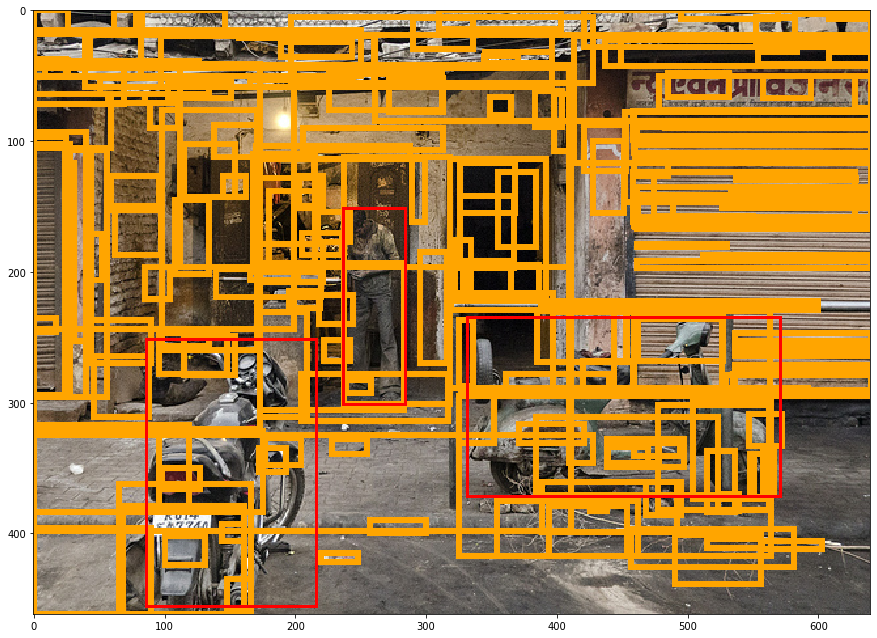

In [8]:
batch = train_dataset.take(1)

for idx, sample in enumerate(batch): 
#     print(sample["image/id"])
    image = sample["image"]
#     print("image shape ", image.shape)
    bboxs = sample["objects"]["bbox"]
#     print("bobxs shape ", bboxs.shape)
    labels = sample["objects"]["label"]
#     print("lables shape ,", labels.shape)
    plt.figure(figsize=(15,15)) 
    plt.imshow(image)
    ax = plt.gca()
    bboxs = convert_to_xywh(bboxs) 
    bboxs = scale_bbox_up(bboxs, (image.shape[0], image.shape[1]))
           
    rois = ROI().generate_roi(image.numpy(), 200, scale=False)
    
    print("matching rois to bbox \n")
    matched_indx, positives, negatives = LabelEncoder()._match_roi_boxes(rois, bboxs)
    print() 
    print("matched_indx", matched_indx)
    print("positives", positives) 
    # generate roi 
    for roi in rois:
            
        rect2 = plt.Rectangle((roi[0], roi[1]), roi[2], roi[3],linewidth=6,edgecolor='orange',facecolor='none')
        ax.add_patch(rect2)

    for bbox_index, (bbox, label) in enumerate(zip(bboxs, labels)): 

        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    break


In [9]:
array_batch = list(batch.as_numpy_iterator())
batch_images = np.array([sample["image"] for sample in array_batch]) 
gt_boxes = np.array([sample["objects"]["bbox"] for sample in array_batch]) 
labels = np.array([sample["objects"]["label"] for sample in array_batch])
labels

array([[3, 3, 0]], dtype=int64)

In [10]:
# encoder = LabelEncoder() 
# processed_batch = encoder.encode_batch(batch_images, gt_boxes, labels)

In [11]:
tf.keras.applications.ResNet50().summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv2_block3_out (Activation)   (None, 56, 56, 256)  0           conv2_block3_add[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_conv (Conv2D)    (None, 28, 28, 128)  32896       conv2_block3_out[0][0]           
__________________________________________________________________________________________________
conv3_block1_1_bn (BatchNormali (None, 28, 28, 128)  512         conv3_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv3_block1_1_relu (Activation (None, 28, 28, 128)  0           conv3_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_2_conv (Conv2D)    (None, 28, 28, 128)  147584      conv3_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv3_bloc

__________________________________________________________________________________________________
conv3_block4_3_bn (BatchNormali (None, 28, 28, 512)  2048        conv3_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block4_add (Add)          (None, 28, 28, 512)  0           conv3_block3_out[0][0]           
                                                                 conv3_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 28, 28, 512)  0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 14, 14, 256)  131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_bloc

__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_relu (Activation (None, 14, 14, 256)  0           conv4_block4_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_3_conv (Conv2D)    (None, 14, 14, 1024) 263168      conv4_block4_2_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_3_bn (BatchNormali (None, 14, 14, 1024) 4096        conv4_block4_3_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_add (Add)          (None, 14, 14, 1024) 0           conv4_block3_out[0][0]           
          

__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_2_relu (Activation (None, 7, 7, 512)    0           conv5_block2_2_bn[0][0]          
__________

In [12]:
def get_backbone(): 
    '''
        basic resnet50 backbone
    '''
    backbone = tf.keras.applications.ResNet50(
        include_top=False, 
        weights="imagenet"
    )
    
    ouput_filters = backbone.get_layer("conv4_block1_1_conv").output
    
    return keras.Model(inputs=[backbone.inputs], outputs=ouput_filters)


def get_head(output_filter): 
    '''
        custom head with 4 convolutions (same padding) and one final convolution with the desired amount of filters
    '''
    head = keras.Sequential([keras.Input(shape=[None, None, 256])]) 
    for i in range(4): 
        head.add(tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"))
        
    head.add(
        keras.layers.Conv2D(
            output_filter,
            3,
            1,
            padding="same"
        )
    )
    
    return head


In [13]:
class RCNN(keras.Model): 
    
    def __init__(self, num_classes, **kwargs): 
        super(RCNN, self).__init__(name="rcnn", **kwargs)
        self.backbone = get_backbone()
        self.num_classes = num_classes
        
        self.clf_head = get_head(9 * num_classes) # 32 filters
        self.regr_head = get_head(9 * 4) # 32 filters
    
    def call(self, image, training=False): 
        # forward pass
        
        output_filter = self.backbone(image) 
        print("received output filters")
        # number of images
        N = tf.shape(image)[0] 
        
        bbox_head_output = self.regr_head(output_filter)
        clf_head_output = self.clf_head(output_filter)
        
        print("raw clf output", clf_head_output.shape)
        print("raw bbox output", bbox_head_output.shape)
        
        # I have no fucking idea of why it's like this ......
        cls_output = tf.reshape(clf_head_output, (N, -1, self.num_classes))
        bbox_output = tf.reshape(bbox_head_output, (N, -1, 4))
        
        print("reshaped clf", cls_output.shape) 
        print("reshaped bbox", bbox_output.shape)
        
        # the last 4 columns will be for the bbox coordinates 
        return tf.concat([bbox_output, cls_output], axis=-1)
            

In [14]:
get_head(9*4).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 256)   590080    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 256)   590080    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 256)   590080    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 256)   590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 36)    82980     
Total params: 2,443,300
Trainable params: 2,443,300
Non-trainable params: 0
_________________________________________________________________


In [15]:
image = cv2.resize(batch_images[0], (224, 224))

In [16]:
rcnn = RCNN(80).call(tf.expand_dims(image, axis=0))
rcnn.shape

received output filters
raw clf output (1, 14, 14, 720)
raw bbox output (1, 14, 14, 36)
reshaped clf (1, 1764, 80)
reshaped bbox (1, 1764, 4)


TensorShape([1, 1764, 84])

In [17]:
# implementing the custom loss function 

def rccn_loss(y_true, y_pred, delta):
    """
        Compute the rcnn loss 
        Argument: 
            y_true : the true output label (m, 84) 
            y_pred : predicted output (m, 84)
            delta: the regulizer
    """
    
    box_labels = y_true[:, :, :4]
    box_predictions = y_pred[:, :, :4]
    
    cls_labels = y_true[:, :, 4:] 
    cls_predictions = y_pred[:, :, 4:] 
    
    positives = tf.cast(tf.greater(cls_labels, -1.0), tf.float32) 
    ignores = tf.cast(tf.equal(cls_labels, -2.0), tf.float32)
    
    # squared diff
    
    squared_diff = tf.math.square(y_pred, y_true)
    mean_squared_diff = tf.math.reduce_sum(squared_diff, axis=-1) 
    
    return mean_squared_diff
    
        


In [18]:
model_dir = "rcnn_dir/" 
label_encoder = LabelEncoder()

num_classes = 80 
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]


In [19]:
resnet50_backbone = get_backbone()
model = RCNN(num_classes=80)

optimizer = tf.optimizers.SGD(learning_rate=learning_rates, momentum=0.9)
model.compile(loss=rccn_loss, optimizer=optimizer)


In [20]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]


In [24]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)


In [25]:
batch_size=32

autotune = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.map(
    preprocess_data
)
train_dataset = train_dataset.shuffle(8 * batch_size)

train_dataset = train_dataset.map(
    label_encoder.encode_batch
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.prefetch(autotune)


AttributeError: in user code:

    <ipython-input-23-dde5fea0393a>:63 preprocess_data  *
        image = tf.make_ndarray(image)
    C:\Users\valentin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\tensor_util.py:597 MakeNdarray  **
        shape = [d.size for d in tensor.tensor_shape.dim]

    AttributeError: 'Tensor' object has no attribute 'tensor_shape'


In [ ]:
# model.fit(
#     train_dataset.take(100),
#     validation_data=val_dataset.take(50),
#     epochs=1,
#     callbacks=callbacks_list,
#     verbose=1,
# )
